## CPCA for fMRI - Python


#### Imports and Dependencies
First add the packages that we'll need. I'll try to use as few dependencies as possible here. We'll need to install nipy, numpy, matplotlib, and scipy if we don't already have them

In [1]:
# install nipy 
# pip3 install --user nipy

import nipy 
import numpy as np
import os
import glob
import scipy.stats as st
import matplotlib.pyplot as plt

#### Data
We'll also need to the data, so make sure we have a reference to that too. This code will change depnding on where you saved the single subject example data. 

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), 'example_data_Single_Subject', 'example_data_Single_Subject'))
subject_path = os.path.abspath(os.path.join(data_path, 's01'))

In [3]:
os.listdir(data_path)

['condition_names.txt',
 'shapes.mat',
 'mask.hdr',
 'mask.img',
 'timing_onsets.m',
 's01']

In [4]:
os.listdir(subject_path)

['fsnruna_F088.img',
 'fsnruna_F038.hdr',
 'fsnruna_F192.img',
 'fsnruna_F104.img',
 'fsnruna_F081.img',
 'fsnruna_F011.img',
 'fsnruna_F054.hdr',
 'fsnruna_F042.img',
 'fsnruna_F130.img',
 'fsnruna_F085.hdr',
 'fsnruna_F164.img',
 'fsnruna_F079.hdr',
 'fsnruna_F140.img',
 'fsnruna_F098.hdr',
 'fsnruna_F078.hdr',
 'fsnruna_F048.hdr',
 'fsnruna_F078.img',
 'fsnruna_F053.hdr',
 'fsnruna_F136.hdr',
 'fsnruna_F046.img',
 'fsnruna_F184.hdr',
 'fsnruna_F035.img',
 'fsnruna_F170.img',
 'fsnruna_F072.hdr',
 'fsnruna_F073.hdr',
 'fsnruna_F167.img',
 'fsnruna_F096.img',
 'fsnruna_F027.img',
 'fsnruna_F115.hdr',
 'fsnruna_F079.img',
 'fsnruna_F148.img',
 'fsnruna_F095.img',
 'fsnruna_F110.hdr',
 'fsnruna_F132.hdr',
 'fsnruna_F203.hdr',
 'fsnruna_F051.hdr',
 'fsnruna_F144.img',
 'fsnruna_F004.hdr',
 'fsnruna_F186.hdr',
 'fsnruna_F188.hdr',
 'fsnruna_F133.img',
 'fsnruna_F059.hdr',
 'fsnruna_F175.img',
 'fsnruna_F010.hdr',
 'fsnruna_F138.hdr',
 'fsnruna_F084.img',
 'fsnruna_F193.img',
 'fsnruna_F01

We can use the python glob function to read in all the images. The \*.img string reads in all the files that end in '.img'

In [5]:
path_to_img = glob.glob(os.path.join(subject_path, '*.img'))
path_to_img.sort() # be careful about naming here, sort(1 2 ..10) will do 1 10 2.... 9 etc. since it's a string sort

In [6]:
len(path_to_img)

214

In [7]:
img_hdr = nipy.load_image(path_to_img[0])
data_img = img_hdr.get_data()

In [8]:
data_img[:,:,:].shape



(40, 48, 34, 1)

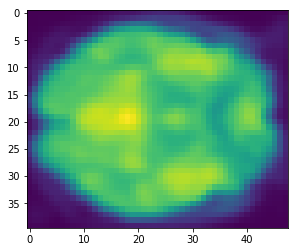

In [9]:
%matplotlib inline
plt.imshow(np.squeeze(data_img[:,:,10]))

We can see there are 214 scans for this subject.

In [10]:
def load_all(img_path):
    img_hdr = nipy.load_image(img_path)
    return img_hdr.get_data()
all_scans = list(map(load_all, path_to_img))
print(len(all_scans))

214


In [11]:
def flatten_scan(scan):
    return np.array(scan).flatten(order = 'F')
brain_scans = np.vstack(list(map(flatten_scan, all_scans)))

In [12]:
brain_scans.shape

(214, 65280)

## Masking 
There are infinite ways of creating an image mask. An mask is an image of zeros and ones that denote the areas to be analyzed. We will use a precreated mask for the purpose of this analysis, but we can easily make our own masking function. For example, we can create a mask by thresholding the scans at the global mean. 

/home/rzlim08/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


29401

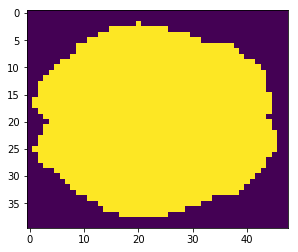

In [13]:
mask = np.sum(brain_scans>np.mean(brain_scans),0)//brain_scans.shape[0]
m = mask.reshape((40, 48, 34), order={"F"})
plt.imshow(np.squeeze(m[:,:,10]))
sum(mask)

For the purposes of this workshop, we'll use a precreated mask.

In [14]:
mask = nipy.load_image(os.path.join(data_path, 'mask.img')).get_data()

To get our data matrix, we will select only the voxels that we've included in our analysis. We call our data matrix Z. 

In [15]:
mask = np.array(mask).flatten(order = 'F')

Z = brain_scans[:,  np.nonzero(mask)[0]]
Z.shape

(214, 29151)

We will want to standardize this matrix. PCA should be mean centered at the very least to return meaningful results. 

In [16]:
Z = st.zscore(Z)

This gives us a standardized data matrix. We will now create a design matrix to represent the timing information

## Creating the Design Matrix (G Matrix)

Since we want to get the neural responses to the task, we want to constain our analysis to the scans where we expect to see these responses. We create our design matrix by inserting ones into the places where we expect to see signals. This is a similar procedure to that used in SPM's first level analysis. 

In [17]:
Letters2=[55.269, 79.074, 89.123, 118.569, 123.266, 138.011, 163.450, 179.190, 189.245];
Letters4=[5.025, 10.383, 20.765, 69.681, 74.377, 108.515, 132.986, 158.425, 199.293];
Letters6=[15.740, 25.789, 40.540, 143.369, 148.727, 168.808, 173.832, 183.887, 194.269];
Letters8=[30.486, 35.844, 45.237, 59.960, 64.656, 84.098, 94.481, 113.211, 128.290];
onsets = [Letters2, Letters4, Letters6, Letters8]

In [18]:
onsets = np.vstack(np.array(onsets))
onsets = np.int64(np.ceil(onsets)-1) # remember, Python is 0 indexed

In [19]:
conditions = onsets.shape[0]
bins = 8
G = np.zeros((Z.shape[0], bins*conditions));
G.shape

(214, 32)

In [20]:
for j in range(0, conditions):
    cond_onsets = onsets[j, :]
    for i in range(0, cond_onsets.shape[0]):
        for k in range(0,bins):
            G[cond_onsets[i]+k, j*bins+k]=1 
G.shape
G = st.zscore(G)


## Regression

We will then regress the Z matrix onto the G matrix. This will give use the betas for the regression. 

In [21]:
G = G
Z = Z
GG = G.T@G
C = np.linalg.pinv(GG)@G.T@Z

## SVD/PCA
Now we can do the singular value decomposition (SVD). SVD is a matrix decomposition technique that will yield equivalent results to PCA. Normally, with multiple participants we'd have to append all the matrices from each participant together, but here we only have a single participant. 

In [22]:
[U, D,  V] = np.linalg.svd(G@C, full_matrices=False)
P = (np.linalg.pinv(GG)@G.T@U)*np.sqrt(G.shape[0])
P[:, 0]

array([ 0.09521415,  0.05015617, -0.10637506, -0.14632599, -0.1486813 ,
       -0.23219647, -0.3083787 , -0.27059127,  0.19704358,  0.21781634,
        0.16258323,  0.07669186,  0.10482465,  0.09993128,  0.07076341,
        0.05029745,  0.10420338,  0.1599304 ,  0.17311438,  0.01497507,
       -0.05802753, -0.15644779, -0.26506782, -0.29651945,  0.42408922,
        0.51506011,  0.53566521,  0.41531119,  0.31167673,  0.18018954,
        0.06871738,  0.04877582])

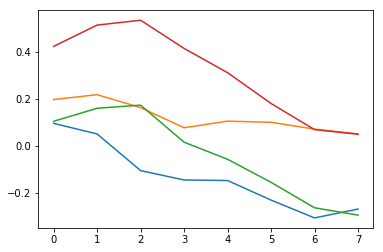

In [23]:
% matplotlib inline
plt.plot(P[0:8, 0])
plt.plot(P[8:16, 0])
plt.plot(P[16:24, 0])
plt.plot(P[24:32, 0])

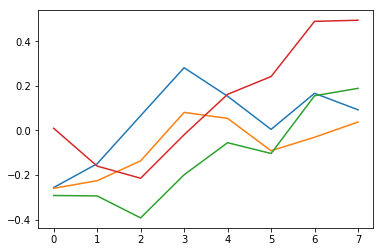

In [24]:
% matplotlib inline
plt.plot(P[0:8, 1])
plt.plot(P[8:16, 1])
plt.plot(P[16:24, 1])
plt.plot(P[24:32, 1])

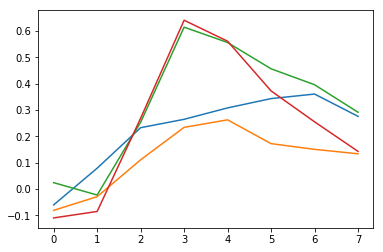

In [25]:
% matplotlib inline
plt.plot(P[0:8, 2])
plt.plot(P[8:16, 2])
plt.plot(P[16:24, 2])
plt.plot(P[24:32, 2])